In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import pandas as pd

C:\Users\39296\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
def custom_loader(inp):
    data=pd.read_csv(inp)
    x=data['CP2']
    x=torch.from_numpy(x.values).float()
    return x 

data_sets=datasets.DatasetFolder('train/', loader=custom_loader, extensions=['.csv'])
ds2=datasets.DatasetFolder('test/', loader=custom_loader, extensions=['.csv'])
train_loader=torch.utils.data.DataLoader(data_sets,
                                          batch_size=32,
                                          shuffle=False,
                                          )
test_loader=torch.utils.data.DataLoader(ds2,
                                          batch_size=32,
                                          shuffle=False,
                                          )

In [45]:
# Very simple lstm model which is modified from https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier
class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.layer_dim=layer_dim
        self.rnn=nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim)
        self.batch_size=None
        self.hidden=None
    
    def forward(self, x):
        out, (hn, cn)=self.rnn(x)
        out=self.fc(out)
        return out
    
  

In [51]:
#Standard Training process, modified from from https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier.
# I changed the optimizer and tuning hyper parameters to avoid overfitting.
np.random.seed(42) # so the model can be reproduced
input_dim=120000   
hidden_dim=256
layer_dim=3
output_dim=2
weight_decay=0.0025

lr=0.05
n_epochs=10
iterations_per_epoch=len(train_loader)
best_acc=0
patience, trials=100, 0
test_accuracies=[]
losses=[]

model=LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model=model.cuda()
criterion=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        x_batch=x_batch.cuda()
        y_batch=y_batch.cuda()
        opt.zero_grad()
        out=model(x_batch)
        loss=criterion(out, y_batch)
        loss.backward()
        opt.step()
    losses.append(loss.item())
    model.eval()
    correct, total=0, 0
    for x_val, y_val in test_loader:
        x_val, y_val=[t.cuda() for t in (x_val, y_val)]
        out=model(x_val)
        preds=F.log_softmax(out, dim=1).argmax(dim=1)
        total +=y_val.size(0)
        correct +=(preds == y_val).sum().item()
    acc=correct / total
    test_accuracies.append(acc)

    if epoch % 5==0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc>best_acc:
        trials=0
        best_acc=acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials+=1
        if trials>=patience:
            print(f'Early stopping on epoch {epoch}')
            break

Epoch 1 best model saved with accuracy: 86.00%
Epoch:   5. Loss: 0.1081. Acc.: 84.00%
Epoch:  10. Loss: 0.1747. Acc.: 92.00%
Epoch 10 best model saved with accuracy: 92.00%


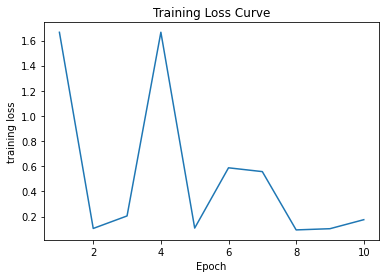

In [55]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,11)), losses)
plt.xlabel("Epoch")
plt.ylabel("training loss")
plt.title("Training Loss Curve")
plt.savefig("LSTMTraining.png")

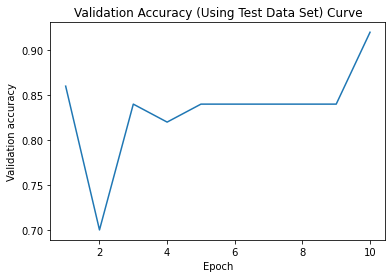

In [56]:
plt.plot(list(range(1,11)), test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation Accuracy (Using Test Data Set) Curve")
plt.savefig("LSTMValidation.png")

In [47]:
torch.cuda.empty_cache() 